## PyMC geomod 3


**Importing**

In [1]:
%matplotlib inline
from IPython.core.display import Image

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import shutil
#import geobayes_simple as gs

import pymc as pm # PyMC 2
from pymc.Matplot import plot
from pymc import graph as gr
import numpy as np
#import daft
from IPython.core.pylabtools import figsize
figsize(12.5, 10)

Couldn't import dot_parser, loading of dot files will not be possible.


In [3]:
# as we have our model and pygeomod in different paths, let's change the pygeomod path to the default path.
sys.path.append("C:\Users\Miguel\workspace\pygeomod\pygeomod")
#sys.path.append(r'/home/jni/git/tmp/pygeomod_tmp')
import geogrid
import geomodeller_xml_obj as gxml
reload(gxml)


<module 'geomodeller_xml_obj' from 'C:\Users\Miguel\workspace\pygeomod\pygeomod\geomodeller_xml_obj.pyc'>

### Coping our Model in a new folder

In [4]:
try:
    shutil.copytree('C:/Users/Miguel/workspace/Thesis/Geomodeller/Basic_case/Simple_Graben_3', 'Temp_Graben/')
except:
    print "The folder is already created"

The folder is already created


## Complex case: Graben
#### Loading pre-made Geomodeller model 

    You have to be very careful with the path, and all the bars to the RIGHT

In [4]:
graben = 'Temp_graben/Simple_Graben_3.xml'#C:\Users\Miguel\workspace\Thesis\Thesis\Temp3
print graben

Temp_graben/Simple_Graben_3.xml


In [5]:
#%%timeit
reload(geogrid)
G1 = geogrid.GeoGrid()

# Using G1, we can read the dimensions of our Murci geomodel
G1.get_dimensions_from_geomodeller_xml_project(graben)

nx = 400
ny = 2
nz = 400
G1.define_regular_grid(nx,ny,nz)

In [6]:
#%%timeit
G1.update_from_geomodeller_project(graben)


Tha axis here represent the number of cells not the real values of geomodeller

C:\Users\Miguel\Anaconda\lib\site-packages\matplotlib\axes\_base.py:1057: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
C:\Users\Miguel\Anaconda\lib\site-packages\matplotlib\axes\_base.py:1062: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


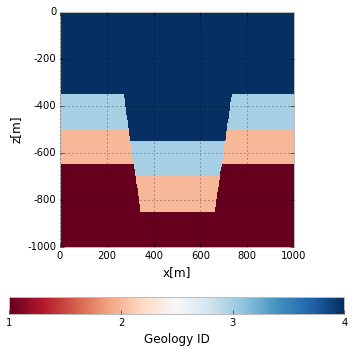

In [8]:
G1.plot_section('y',cell_pos=1,colorbar = True,  cmap='RdBu', figsize=(6,6),interpolation= 'nearest' ,ve = 1, geomod_coord= True)

####Setting Bayes Model

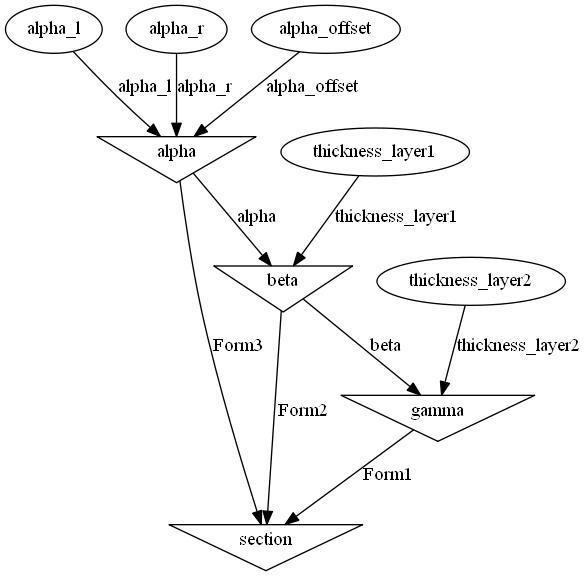

In [61]:
Image("Geomodeller_no_const.png")

In [18]:
# First layer
alpha_l = pm.Normal("alpha_l", -350, 0.5, value= -250)
alpha_r = pm.Normal("alpha_r", -300, 0.5)

#Thickness of the layers
thickness_layer1 = pm.Normal("thickness_layer1", -150, 0.005) # a lot of uncertainty so the constrains are necessary
thickness_layer2 = pm.Normal("thickness_layer2", -150, 0.005)

# Offset
alpha_offset = pm.Normal("alpha_offset",-550,0.5)


@pm.deterministic
def alpha(alpha_l = alpha_l, alpha_r = alpha_r, alpha_offset = alpha_offset):
    return [alpha_offset, alpha_l, alpha_r ]
 
@pm.deterministic
def beta(alpha = alpha, thickness_layer1 = thickness_layer1):
    return alpha + thickness_layer1

@pm.deterministic
def gamma(beta = beta, thickness_layer2 = thickness_layer2):
    return beta + thickness_layer2


@pm.deterministic
def section(Form3 = alpha, Form2 = beta , Form1 = gamma):
    # Create the array we will use to modify the xml. We have to check the order of the formations
    #print alpha, alpha.value
    print Form3
    samples =  zip(Form3,Form2, Form1)
    samples = np.reshape(samples, -1 )
  #  print samples
    print samples
    # Load the xml to be modify
    org_xml = 'Temp_graben\Simple_Graben_3.xml'
    
    #Create the instance to modify the xml
        # Loading stuff
    reload(gxml)
    gmod_obj = gxml.GeomodellerClass()
    gmod_obj.load_geomodeller_file(org_xml)
    
    # Create a dictionary so we can acces the section through the name
    section_dict = gmod_obj.create_sections_dict()
    
    # ## Get the points of all formation for a given section: Dictionary
    contact_points = gmod_obj.get_formation_point_data(section_dict['Section1'])
    
    # Check the position of points you want to change
    points_changed = gmod_obj.get_point_coordinates(contact_points)
   # print "Points coordinates", points_changed
   # print len(contact_points[:-4])
    
    #Perform the position Change
    for i, point in enumerate(contact_points[:-4]):
        gmod_obj.change_formation_point_pos(point, y_coord = [samples[i],samples[i]])#, print_points = True)
    
    # Check the new position of points
              #points_changed = gmod_obj.get_point_coordinates(contact_points)
              #print "Points coordinates", points_changed
    
    # Write the new xml
    gmod_obj.write_xml("Temp_graben/new.xml")
       
    # Read the new xml
    new_xml = 'Temp_graben/new.xml'
    G1 = geogrid.GeoGrid()
    
    # Getting dimensions and definning grid
    
    G1.get_dimensions_from_geomodeller_xml_project(new_xml)
    
    # Resolution!
    nx = 400
    ny = 2
    nz = 400
    G1.define_regular_grid(nx,ny,nz)
    
    # Updating project
    G1.update_from_geomodeller_project(new_xml)
   # G1.plot_section('y',cell_pos=1,colorbar = True,  cmap='RdBu', figsize=(6,6),interpolation= 'nearest' ,ve = 1, geomod_coord= True, contour = True)
    #print "I am here"
    return G1

print alpha, type(alpha)



#MODEL!!
model = pm.Model([alpha_l,alpha_r,alpha_offset,thickness_layer1, thickness_layer2,alpha,beta,gamma,section])

[array(-549.2606816160599), array(-250.0), array(-298.6058561895746)]
[-549.26068162 -700.47962961 -829.89065749 -250.         -401.218948
 -530.62997588 -298.60585619 -449.82480419 -579.23583207]
alpha <class 'pymc.PyMCObjects.Deterministic'>


In [10]:
alpha_l.value

array(-250.0)

In [16]:
M = pm.MCMC(model)
M.sample(iter=20)

alpha [array(-551.0386682225075), array(-351.59078440209237), array(-299.7497891768681)]
 [---              10%                  ] 2 of 20 complete in 3.5 secalpha [array(-551.79219753635), array(-348.8644479736964), array(-299.6013621420937)]
 [-----            15%                  ] 3 of 20 complete in 6.8 secalpha [array(-551.8412524764105), array(-349.1357656484327), array(-300.1205168346977)]
 [-------          20%                  ] 4 of 20 complete in 10.1 secalpha [array(-549.8661730939244), array(-351.54612983814826), array(-299.34800882559847)]
 [---------        25%                  ] 5 of 20 complete in 13.3 secalpha [array(-550.7952568391308), array(-351.6191676981028), array(-298.32746775448794)]
 [-----------      30%                  ] 6 of 20 complete in 16.6 secalpha [array(-549.4954961764308), array(-350.0644980532205), array(-300.72358619511044)]
 [-------------    35%                  ] 7 of 20 complete in 19.8 secalpha [array(-551.137397906036), array(-349.5299350

In [60]:
a = gr.dag(M)
a.write_png("Geomodeller_no_const.png")

True

** Extracting Posterior Traces to Arrays **

In [54]:
n_samples = 9

alpha_samples, alpha_samples_all = M.trace('alpha')[-n_samples:], M.trace("alpha")[:]
beta_samples, beta_samples_all = M.trace('beta')[-n_samples:], M.trace("beta")[:]
gamma_samples, gamma_samples_all = M.trace('gamma')[-n_samples:], M.trace('gamma')[:]
section_samples, section_samples_all = M.trace('section')[-n_samples:], M.trace('section')[:]

** Plotting the results **

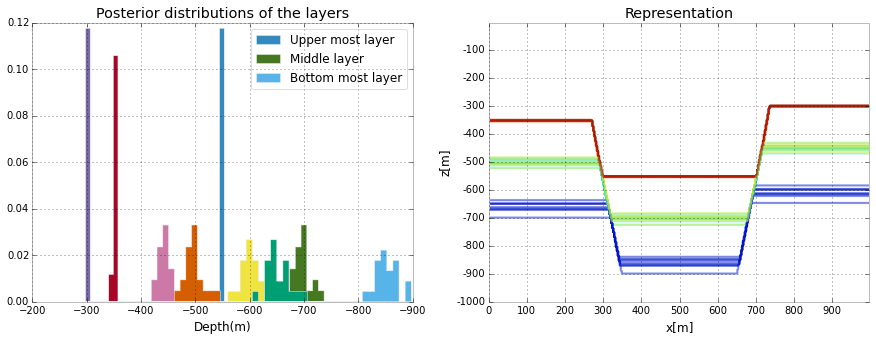

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(alpha_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Upper most layer", normed=True)

ax[0].hist(beta_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Middle layer", normed=True)#, color = "g")

ax[0].hist(gamma_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Bottom most layer", normed=True)#, color = "r")


ax[0].invert_xaxis()
ax[0].legend()
ax[0].set_title(r"""Posterior distributions of the layers""")
ax[0].set_xlabel("Depth(m)")


ax[1].set_title("Representation")


for i in section_samples:
    i.plot_section('y',cell_pos=1,colorbar = True,  ax = ax[1], alpha = 0.3, figsize=(6,6),interpolation= 'nearest' ,ve = 1, geomod_coord= True, contour = True)

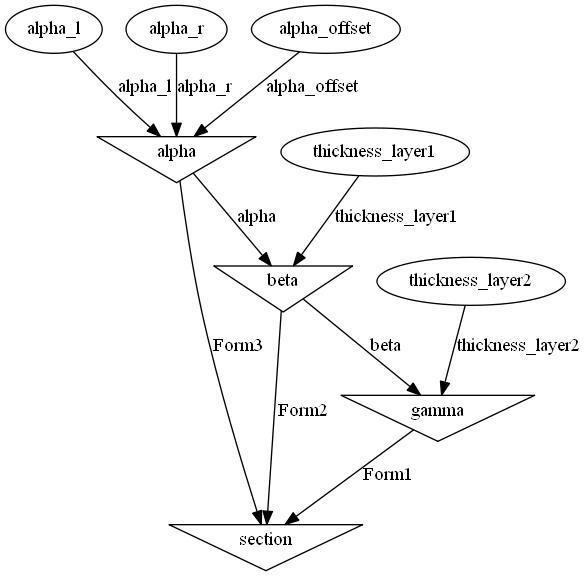

In [2]:
Image("Geomodeller_no_const.png")

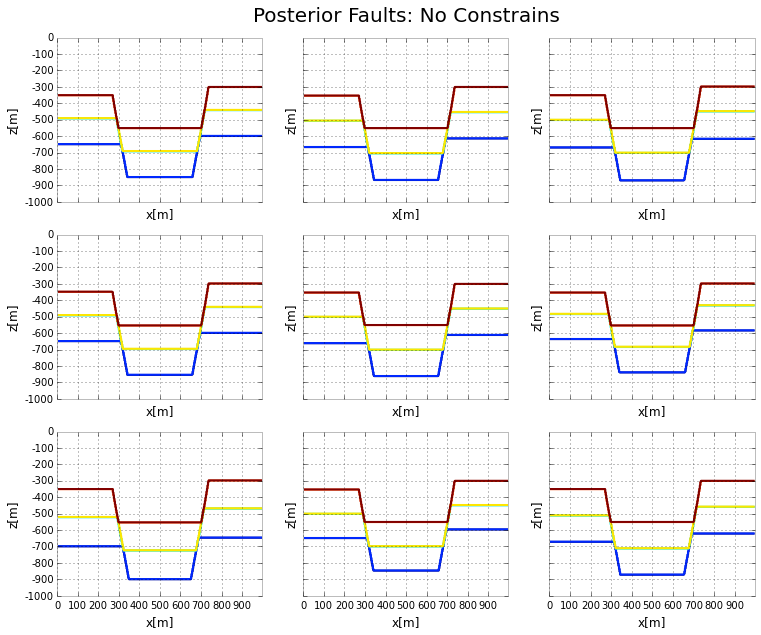

In [57]:
i = 0
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True)

plt.text(0.5, 1.1, "Posterior Faults: No Constrains",
     horizontalalignment='center',
        fontsize=20,
        transform = axs[0,1].transAxes)
#plt.subplots_adjust(top=2.15)
#axs[0,1].set_title("Posterior Faults: Non-Constrains", fontsize=20)

for i, g  in enumerate(section_samples):
    g.plot_section('y',cell_pos=1,colorbar = True,  ax = axs[i- 3*(i/3),i/3], alpha = 1, figsize=(6,6),interpolation= 'nearest' ,ve = 1, geomod_coord= True, contour = True)
     

Plotting gamma_0
Plotting gamma_1
Plotting gamma_2
Plotting thickness_layer1
Plotting thickness_layer2
Plotting alpha_offset
Plotting alpha_r
Plotting alpha_l
Plotting beta_0
Plotting beta_1
Plotting beta_2


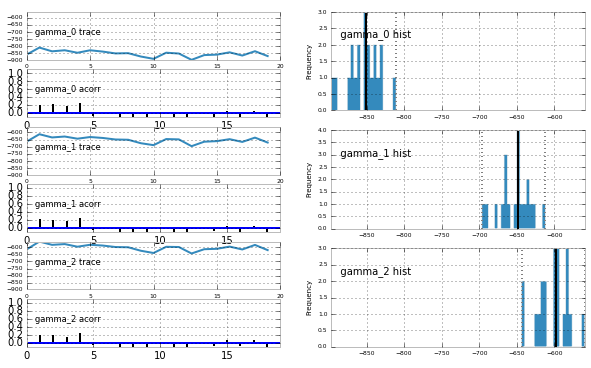

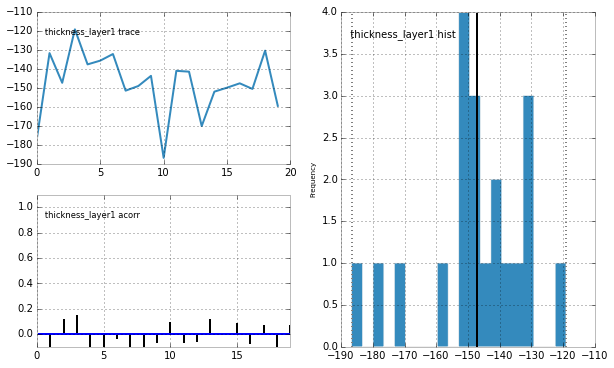

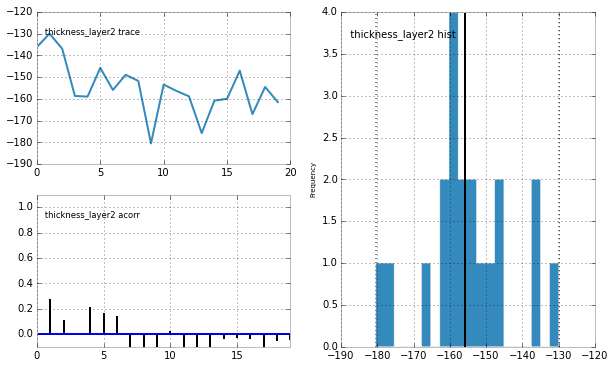

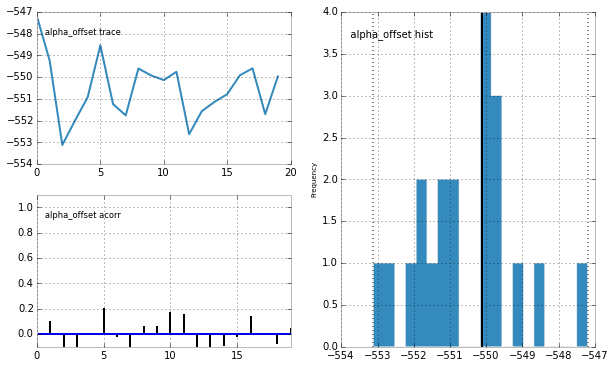

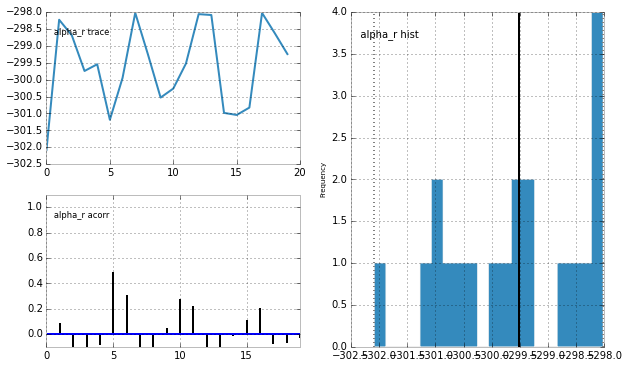

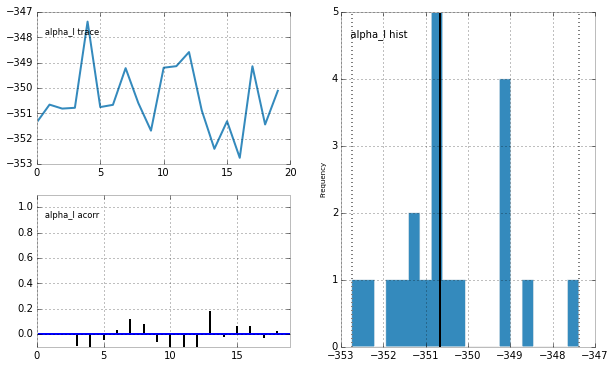

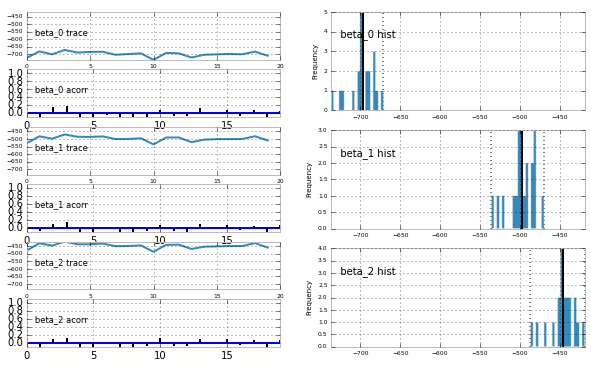

In [58]:
plot(M)